## PETSc Email Traceback Categorization
### Author: carterp@cs.uoregon.edu

Examines PETSc emails for tracebacks and attempts to categorize them using pattern matching. Based on the notebook `anl_email_viewer.ipynb` by Stephen Fickas (https://colab.research.google.com/drive/1gGiUd8670052ZwLF531d2BcxdMnDkjtu?usp=sharing).

#### Load PETSc email table

This was generated by a prior notebook. Emails are ordered chronologically.

In [ ]:
import pandas as pd

In [ ]:
url = 'https://www.dropbox.com/s/jcmryynu9j8kyf4/sorted_petsc_email.csv?raw=1'

In [ ]:
email_table = pd.read_csv(url)
email_table = email_table.drop(columns=['Unnamed: 0'])
email_table.head(10)

,Date,From,In-Reply-To,Message-ID,References,Subject,Cleaned,Payload,Scott-Grad-MBP,DEAL,CleanedDate
0,"Wed, 24 Jun 2020 00:13:13 +0530",shaswat121994 at gmail.com (Shashwat Tiwari),<CAMYG4GmfmZPsByi32yKXVpT13fDTq0Upk-Zuuaj8Z1r5...,<CADw7kHWWDf+f5K-b80+XtY+kUbuQXPCGQ=dxZXgV=r4m...,<CADw7kHW19gYWT_4W_Tj0OVyoGYA8LhAGv2hT9EjYp1Yd...,[petsc-users] Implementing periodicity using D...,"['On Sat, Jun 20, 2020 at 2:41 AM Matthew Knep...","On Sat, Jun 20, 2020 at 2:41 AM Matthew Kneple...",NaN,NaN,2020-06-24 00:13:13+05:30
1,"Tue, 23 Jun 2020 15:49:43 +0000",bantingl at myumanitoba.ca (Lucas Banting),<CAMYG4G=yoLvPwF88n6Vv8eTcB-1wZqEodGWMsVxuZESD...,<YTOPR0101MB2185123E6474F68DE52A33A5B1940@YTOP...,<YTOPR0101MB21859212E759CDC79896C126B1940@YTOP...,[petsc-users] Question about HDF5 Viewer and D...,"['Thank you both.', '', 'The reason the sequen...",Thank you both.\n\nThe reason the sequential o...,NaN,NaN,2020-06-23 15:49:43+00:00
2,"Tue, 23 Jun 2020 11:16:49 -0400",mfadams at lbl.gov (Mark Adams),<CAGPUisgFNw+HYDdc6qTjMp7L+AYnntK4dVxSjxOXnxE-...,<CADOhEh68fdqKfL3Pu9CVCvi=4JbdS5iBR=EwfX1KQv1c...,<CADOhEh6EH+rzJheVpOX3xHdawYzBU=p98hP_JdOKeN4y...,[petsc-users] CUDA error,"[""I run in an interactive shell on SUMMIT and ...",I run in an interactive shell on SUMMIT and do...,NaN,NaN,2020-06-23 11:16:49-04:00
3,"Tue, 23 Jun 2020 10:08:10 -0500",junchao.zhang at gmail.com (Junchao Zhang),<CADOhEh6vVRhG0M+Mcew-haDm8XFLQ3y6t5Vnmeq2a46J...,<CA+MQGp-8tBOFUJsiFLubp63DC7k3FKzGUrUHLa2ct_rD...,<CADOhEh6EH+rzJheVpOX3xHdawYzBU=p98hP_JdOKeN4y...,[petsc-users] CUDA error,"['On Tue, Jun 23, 2020 at 9:51 AM Mark Adams <...","On Tue, Jun 23, 2020 at 9:51 AM Mark Adams <mf...",NaN,NaN,2020-06-23 10:08:10-05:00
4,"Tue, 23 Jun 2020 18:07:07 +0300",stefano.zampini at gmail.com (Stefano Zampini),<CADOhEh6vVRhG0M+Mcew-haDm8XFLQ3y6t5Vnmeq2a46J...,<CAGPUisgFNw+HYDdc6qTjMp7L+AYnntK4dVxSjxOXnxE-...,<CADOhEh6EH+rzJheVpOX3xHdawYzBU=p98hP_JdOKeN4y...,[petsc-users] CUDA error,['What did it? How are you running now to have...,What did it? How are you running now to have e...,NaN,NaN,2020-06-23 18:07:07+03:00
5,"Tue, 23 Jun 2020 10:51:31 -0400",mfadams at lbl.gov (Mark Adams),<871rm5zy4c.fsf@jedbrown.org>,<CADOhEh6vVRhG0M+Mcew-haDm8XFLQ3y6t5Vnmeq2a46J...,<CADOhEh6EH+rzJheVpOX3xHdawYzBU=p98hP_JdOKeN4y...,[petsc-users] CUDA error,"['On Tue, Jun 23, 2020 at 9:54 AM Jed Brown <j...","On Tue, Jun 23, 2020 at 9:54 AM Jed Brown <jed...",NaN,NaN,2020-06-23 10:51:31-04:00
6,"Tue, 23 Jun 2020 09:33:02 -0500",bsmith at petsc.dev (Barry Smith),NaN,<6BB8BBA2-3964-494F-9412-B0AD34298BB3@petsc.dev>,NaN,[petsc-users] Open discussion on PETSc's futur...,"['', "" We've open a broad general discussio...",\n We've open a broad general discussion on...,NaN,NaN,2020-06-23 09:33:02-05:00
7,"Tue, 23 Jun 2020 07:54:11 -0600",jed at jedbrown.org (Jed Brown),<CADOhEh6EH+rzJheVpOX3xHdawYzBU=p98hP_JdOKeN4y...,<871rm5zy4c.fsf@jedbrown.org>,<CADOhEh6EH+rzJheVpOX3xHdawYzBU=p98hP_JdOKeN4y...,[petsc-users] CUDA error,"['Did you use --smpiargs=-gpu, and have you tr...","Did you use --smpiargs=-gpu, and have you trie...",NaN,NaN,2020-06-23 07:54:11-06:00
8,"Tue, 23 Jun 2020 09:49:07 -0400",mfadams at lbl.gov (Mark Adams),NaN,<CADOhEh6EH+rzJheVpOX3xHdawYzBU=p98hP_JdOKeN4y...,NaN,[petsc-users] CUDA error,['My code runs OK on SUMMIT but ex56 does not....,My code runs OK on SUMMIT but ex56 does not. e...,NaN,NaN,2020-06-23 09:49:07-04:00
9,"Tue, 23 Jun 2020 09:15:24 -0400",knepley at gmail.com (Matthew Knepley),<YTOPR0101MB21859212E759CDC79896C126B1940@YTOP...,<CAMYG4G=yoLvPwF88n6Vv8eTcB-1wZqEodGWMsVxuZESD...,<YTOPR0101MB21859212E759CDC79896C126B1940@YTOP...,[petsc-users] Question about HDF5 Viewer and D...,"['On Tue, Jun 23, 2020 at 8:56 AM Lucas Bantin...","On Tue, Jun 23, 2020 at 8:56 AM Lucas Banting ...",NaN,NaN,2020-06-23 09:15:24-04:00


In [ ]:
len(email_table)

41507

#### Create subset of just questions

Questions are defined as email with a NaN References value. They are the first email in a thread. Could also use a NaN in the In-Reply-To	column to flag them.

In [ ]:
question_table = email_table[email_table['References'].isnull()]  #create a subtable of questions

In [ ]:
question_table.head()

,Date,From,In-Reply-To,Message-ID,References,Subject,Cleaned,Payload,Scott-Grad-MBP,DEAL,CleanedDate
6,"Tue, 23 Jun 2020 09:33:02 -0500",bsmith at petsc.dev (Barry Smith),NaN,<6BB8BBA2-3964-494F-9412-B0AD34298BB3@petsc.dev>,NaN,[petsc-users] Open discussion on PETSc's futur...,"['', "" We've open a broad general discussio...",\n We've open a broad general discussion on...,NaN,NaN,2020-06-23 09:33:02-05:00
8,"Tue, 23 Jun 2020 09:49:07 -0400",mfadams at lbl.gov (Mark Adams),NaN,<CADOhEh6EH+rzJheVpOX3xHdawYzBU=p98hP_JdOKeN4y...,NaN,[petsc-users] CUDA error,['My code runs OK on SUMMIT but ex56 does not....,My code runs OK on SUMMIT but ex56 does not. e...,NaN,NaN,2020-06-23 09:49:07-04:00
11,"Tue, 23 Jun 2020 12:55:52 +0000",bantingl at myumanitoba.ca (Lucas Banting),NaN,<YTOPR0101MB21859212E759CDC79896C126B1940@YTOP...,NaN,[petsc-users] Question about HDF5 Viewer and D...,"['Hello,', '', 'I am trying to use the HDF5 vi...","Hello,\n\nI am trying to use the HDF5 viewer t...",NaN,NaN,2020-06-23 12:55:52+00:00
17,NaN,NaN,NaN,NaN,NaN,NaN,['Having worked with cohesive elements for mor...,Having worked with cohesive elements for more ...,NaN,NaN,2020-06-22 16:22:30+00:00
23,"Mon, 22 Jun 2020 14:14:08 +0300",eda.oktay at metu.edu.tr (Eda Oktay),NaN,<CA+vu_XidzNXPGoD_JpVpMOebNTEjion-FuxCJOUUraWL...,NaN,[petsc-users] Create MATSEQAIJ from MATMPIAIJ,"['Hello everyone,', '', 'I am trying to find e...","Hello everyone,\n\nI am trying to find element...",NaN,NaN,2020-06-22 14:14:08+03:00


In [ ]:
len(question_table)  #8K questions out of 40K email total

8019

In [ ]:
question_table_reindexed = question_table.reset_index(drop=True)  #Start index over at 0

In [ ]:
question_table_reindexed.head()

,Date,From,In-Reply-To,Message-ID,References,Subject,Cleaned,Payload,Scott-Grad-MBP,DEAL,CleanedDate
0,"Tue, 23 Jun 2020 09:33:02 -0500",bsmith at petsc.dev (Barry Smith),NaN,<6BB8BBA2-3964-494F-9412-B0AD34298BB3@petsc.dev>,NaN,[petsc-users] Open discussion on PETSc's futur...,"['', "" We've open a broad general discussio...",\n We've open a broad general discussion on...,NaN,NaN,2020-06-23 09:33:02-05:00
1,"Tue, 23 Jun 2020 09:49:07 -0400",mfadams at lbl.gov (Mark Adams),NaN,<CADOhEh6EH+rzJheVpOX3xHdawYzBU=p98hP_JdOKeN4y...,NaN,[petsc-users] CUDA error,['My code runs OK on SUMMIT but ex56 does not....,My code runs OK on SUMMIT but ex56 does not. e...,NaN,NaN,2020-06-23 09:49:07-04:00
2,"Tue, 23 Jun 2020 12:55:52 +0000",bantingl at myumanitoba.ca (Lucas Banting),NaN,<YTOPR0101MB21859212E759CDC79896C126B1940@YTOP...,NaN,[petsc-users] Question about HDF5 Viewer and D...,"['Hello,', '', 'I am trying to use the HDF5 vi...","Hello,\n\nI am trying to use the HDF5 viewer t...",NaN,NaN,2020-06-23 12:55:52+00:00
3,NaN,NaN,NaN,NaN,NaN,NaN,['Having worked with cohesive elements for mor...,Having worked with cohesive elements for more ...,NaN,NaN,2020-06-22 16:22:30+00:00
4,"Mon, 22 Jun 2020 14:14:08 +0300",eda.oktay at metu.edu.tr (Eda Oktay),NaN,<CA+vu_XidzNXPGoD_JpVpMOebNTEjion-FuxCJOUUraWL...,NaN,[petsc-users] Create MATSEQAIJ from MATMPIAIJ,"['Hello everyone,', '', 'I am trying to find e...","Hello everyone,\n\nI am trying to find element...",NaN,NaN,2020-06-22 14:14:08+03:00


#### Build set of PETSc Manual Page
Each PETSc manual page will represent a keyword for tagging. Each keyword has a level and parent section that will allow for more options when tagging the stack traces.

In [ ]:
from html.parser import HTMLParser
import urllib.request as urllib2

In [ ]:
manuals_url = 'https://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/singleindex.html'
manual_root_url = "https://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/"

In [ ]:
url_to_page = lambda url : str(urllib2.urlopen(url).read())
manuals = url_to_page(manuals_url)

In [ ]:
petsc_table = pd.DataFrame(columns=["Name", "Section", "Category", "Link"])

In [ ]:
root_pages = set()

In [ ]:
categories = ["beginner", "intermediate", "advanced", "developer", "deprecated"]

In [ ]:
class CategoryParser(HTMLParser):
    prev = None
    
    def handle_data(self, data):
            for c in categories:
                if c in data.lower():
                    CategoryParser.prev = c
                    break
            if all(cat not in data.lower() and not data.isspace() and data for cat in categories):
                global petsc_table
                petsc_table.loc[petsc_table["Name"] == data, "Category"] = CategoryParser.prev

In [ ]:
class MissedCategoryParser(HTMLParser):
    prev = None
    name = None
    
    def handle_data(self, data):
            if MissedCategoryParser.prev == "Level":
                global petsc_table
                petsc_table.loc[petsc_table["Name"] == MissedCategoryParser.name, "Category"] = data
            MissedCategoryParser.prev = data

In [ ]:
class ManualPagesParser(HTMLParser):
    cp = CategoryParser()
    
    def handle_starttag(self, tag, attrs):
        if tag == "a":
            for name, value in attrs:
                if name == "href" and "singleindex.html" not in value and value != "./":
                    name = value[2:-5]
                    name = name[name.index('/') + 1:]
                    
                    page_url = manual_root_url + value[2:]
                    
                    end = len(value) - value[::-1].index("/") - 1
                    section = value[2:end]
                    root_pages.add(section)
                    
                    
                    global petsc_table
                    petsc_table = petsc_table.append({"Name" : name, "Section" : section, "Link" : page_url}, ignore_index=True)

In [ ]:
parser = ManualPagesParser()
parser.feed(manuals)

In [ ]:
petsc_table.head()

,Name,Section,Category,Link
0,ADD_VALUES,Sys,NaN,https://www.mcs.anl.gov/petsc/petsc-current/do...
1,AOCreateMappingIS,AO,NaN,https://www.mcs.anl.gov/petsc/petsc-current/do...
2,AOPetscToApplicationPermuteInt,AO,NaN,https://www.mcs.anl.gov/petsc/petsc-current/do...
3,ADMM_UPDATE_ADAPTIVE_RELAXED,Tao,NaN,https://www.mcs.anl.gov/petsc/petsc-current/do...
4,AOCreateMemoryScalable,AO,NaN,https://www.mcs.anl.gov/petsc/petsc-current/do...


In [ ]:
root_pages

{'AO',
 'Characteristic',
 'DM',
 'DMDA',
 'DMFOREST',
 'DMLABEL',
 'DMMOAB',
 'DMNetwork',
 'DMPATCH',
 'DMPLEX',
 'DMPRODUCT',
 'DMSTAG',
 'DMSWARM',
 'DT',
 'DUALSPACE',
 'Draw',
 'FE',
 'FV',
 'IS',
 'KSP',
 'Mat',
 'MatFD',
 'MatOrderings',
 'PC',
 'PF',
 'PetscSF',
 'PetscSection',
 'Profiling',
 'SNES',
 'SNESFAS',
 'SPACE',
 'Sensitivity',
 'Sys',
 'TS',
 'Tao',
 'TaoLineSearch',
 'Vec',
 'Viewer'}

In [ ]:
get_table_from_html = lambda page : page[page.index("<TABLE"):page.index("</TABLE>") + len("</TABLE>")].replace("\\n", "")

In [ ]:
cp = CategoryParser()

In [ ]:
for rp in root_pages:
    page_url = manual_root_url + rp + "/index.html"
    page = url_to_page(page_url)
    body = get_table_from_html(page)
    cp.feed(body)

In [ ]:
petsc_table.head()

,Name,Section,Category,Link
0,ADD_VALUES,Sys,beginner,https://www.mcs.anl.gov/petsc/petsc-current/do...
1,AOCreateMappingIS,AO,beginner,https://www.mcs.anl.gov/petsc/petsc-current/do...
2,AOPetscToApplicationPermuteInt,AO,beginner,https://www.mcs.anl.gov/petsc/petsc-current/do...
3,ADMM_UPDATE_ADAPTIVE_RELAXED,Tao,advanced,https://www.mcs.anl.gov/petsc/petsc-current/do...
4,AOCreateMemoryScalable,AO,beginner,https://www.mcs.anl.gov/petsc/petsc-current/do...


In [ ]:
sum(len(petsc_table[petsc_table["Category"] == cat]) for cat in categories) # check for uncategorized keywords

5763

In [ ]:
mcp = MissedCategoryParser() # match uncategorized keywords

In [ ]:
uncategorized_urls = petsc_table.loc[~ petsc_table["Category"].isin(categories)]["Link"].tolist()

In [ ]:
uncategorized_names = petsc_table.loc[~ petsc_table["Category"].isin(categories)]["Name"].tolist()

In [ ]:
for url, name in zip(uncategorized_urls, uncategorized_names):
    page = url_to_page(url)
    MissedCategoryParser.name = name
    mcp.feed(page)

In [ ]:
len(petsc_table)

5765

In [ ]:
means = petsc_table.Section.value_counts()
means.keys()

Index(['Sys', 'Mat', 'TS', 'PC', 'SNES', 'DM', 'KSP', 'Vec', 'DMPLEX', 'Tao',
       'Viewer', 'Draw', 'IS', 'Profiling', 'DT', 'DMDA', 'MatOrderings',
       'PetscSection', 'DMMOAB', 'DUALSPACE', 'PetscSF', 'Sensitivity', 'FE',
       'FV', 'DMSTAG', 'DMNetwork', 'DMSWARM', 'SPACE', 'DMFOREST',
       'TaoLineSearch', 'SNESFAS', 'DMLABEL', 'AO', 'PF', 'MatFD',
       'Characteristic', 'DMPRODUCT', 'DMPATCH'],
      dtype='object')

In [ ]:
labels = means.keys()

In [ ]:
data = {k : [] for k in categories}
data

{'advanced': [],
 'beginner': [],
 'deprecated': [],
 'developer': [],
 'intermediate': []}

In [ ]:
for sec in means.keys():
    vals = petsc_table.loc[petsc_table["Section"] == sec, "Category"].value_counts()
    for c in categories:
        if c not in vals:
            vals[c] = 0
        data[c].append(vals[c])

In [ ]:
import copy
ndata = copy.deepcopy(data)
print(categories)
for i, sec in enumerate(labels):
    print(sec)
    print(means[sec])
    s = 0
    for c in categories:
        ndata[c][i] /= means[sec]
        print(data[c][i], end=" ")
        s += data[c][i]
    print()
    print(s)
    print("-" * 30)

['beginner', 'intermediate', 'advanced', 'developer', 'deprecated']
Sys
678
127 178 116 114 143 
678
------------------------------
Mat
570
116 373 5 76 0 
570
------------------------------
TS
506
99 160 149 93 5 
506
------------------------------
PC
404
35 216 103 50 0 
404
------------------------------
SNES
368
62 144 89 73 0 
368
------------------------------
DM
340
51 105 106 78 0 
340
------------------------------
KSP
324
63 139 92 30 0 
324
------------------------------
Vec
316
79 73 112 50 2 
316
------------------------------
DMPLEX
297
48 96 31 122 0 
297
------------------------------
Tao
204
51 52 66 35 0 
204
------------------------------
Viewer
200
39 73 58 30 0 
200
------------------------------
Draw
158
28 78 45 7 0 
158
------------------------------
IS
149
22 55 49 23 0 
149
------------------------------
Profiling
109
1 26 16 66 0 
109
------------------------------
DT
106
31 62 2 11 0 
106
------------------------------
DMDA
104
14 62 15 12 1 
104
-----------

#### Visualize Keywords
Segmented bar chart with each bar representing a PETSc section partitioned into 5 categories denoting the level of each keyword.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


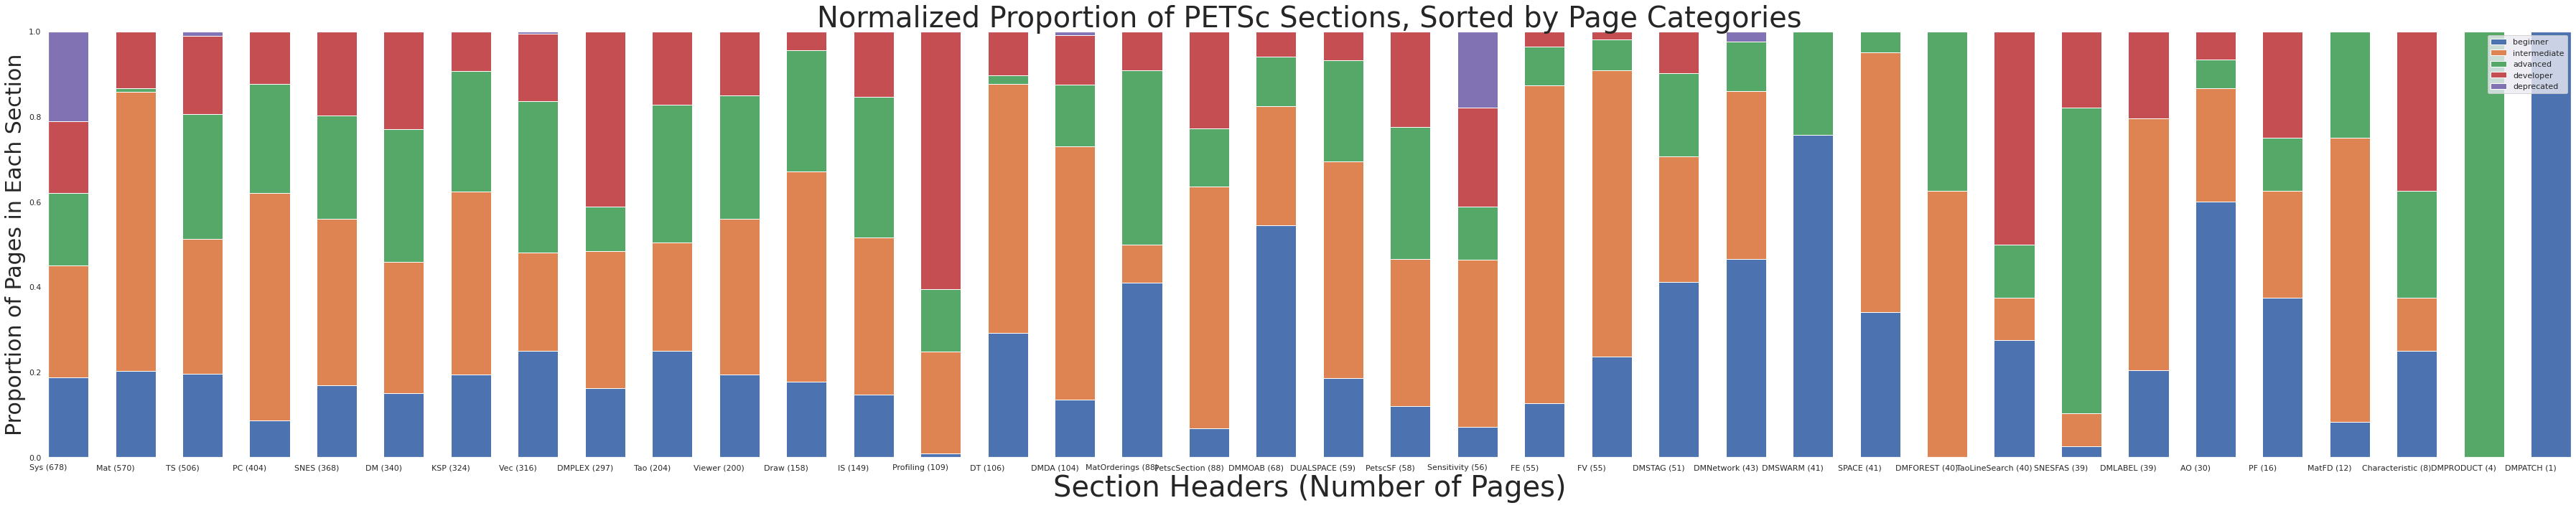

In [ ]:
fig, ax = plt.subplots(figsize=(50,10))
width = 0.6
x = np.arange(len(labels))
normalize = True
if normalize:
    nlabels = [l + f" ({means[l]})" for l in labels]
    b1 = ax.bar(nlabels, ndata["beginner"], width, label="beginner", align="edge")
    b2 = ax.bar(nlabels, ndata["intermediate"], width, label="intermediate", align="edge", 
       bottom=ndata["beginner"])
    b3 = ax.bar(nlabels, ndata["advanced"], width, label="advanced", align="edge",
       bottom=[sum(x) for x in zip(ndata["beginner"], ndata["intermediate"])])
    b4 = ax.bar(nlabels, ndata["developer"], width, label="developer", align="edge",
       bottom=[sum(x) for x in zip(ndata["beginner"], ndata["intermediate"], ndata["advanced"])])
    b5 = ax.bar(nlabels, ndata["deprecated"], width, label="deprecated", align="edge",
       bottom=[sum(x) for x in zip(ndata["beginner"], ndata["intermediate"], ndata["advanced"], ndata["developer"])])
else:
    ax.bar(labels, data["beginner"], width, label="beginner", align="edge")
    ax.bar(labels, data["intermediate"], width, label="intermediate", align="edge", 
       bottom=data["beginner"])
    ax.bar(labels, data["advanced"], width, label="advanced", align="edge",
       bottom=[sum(x) for x in zip(data["beginner"], data["intermediate"])])
    ax.bar(labels, data["developer"], width, label="developer", align="edge",
       bottom=[sum(x) for x in zip(data["beginner"], data["intermediate"], data["advanced"])])
    ax.bar(labels, data["deprecated"], width, label="deprecated", align="edge",
       bottom=[sum(x) for x in zip(data["beginner"], data["intermediate"], data["advanced"], data["developer"])])

ax.set_title("Normalized Proportion of PETSc Sections, Sorted by Page Categories", fontsize=40)
ax.set_xlabel("Section Headers (Number of Pages)", fontsize=40)
ax.set_ylabel("Proportion of Pages in Each Section", fontsize=30)
ax = plt.gca()
ax.set_facecolor('xkcd:white')
ax.autoscale(tight=True)
ax.legend()
fig.tight_layout()
#fig.savefig('temp.svg', format='svg')
plt.show()

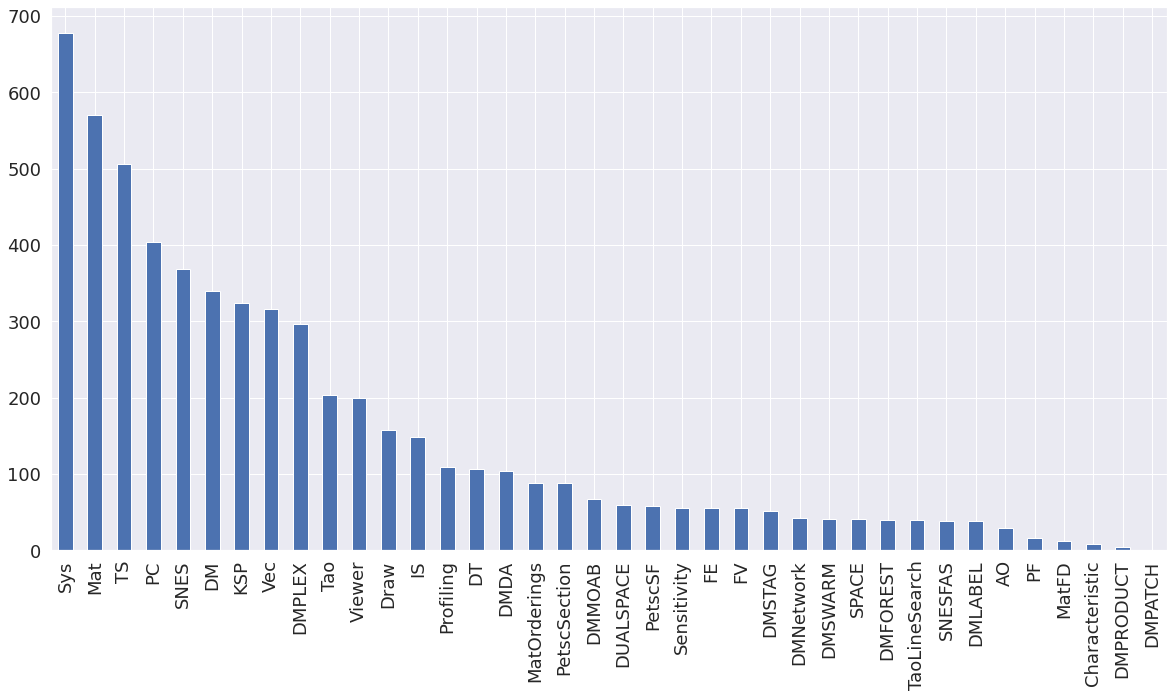

In [ ]:
petsc_table.Section.value_counts().plot(kind="bar", figsize=(20,10), fontsize=18, x="PETSc Sections",);

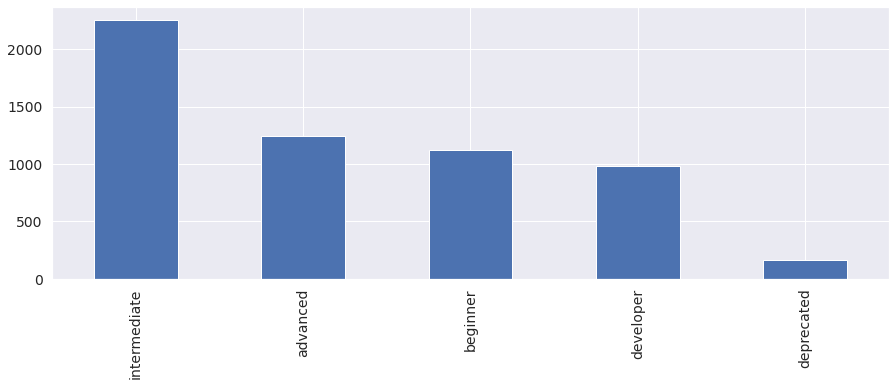

In [ ]:
petsc_table.Category.value_counts().plot(kind="bar", figsize=(15,5), fontsize=14);

#### Search first $k$ questions for those containing a valid PETSc stack trace
Valid searches will be denoted as `good_questions`and its index will be the head of the message chain dictionary. The values will be a list of indicies corresponding to emails in the email threads.

In [ ]:
import re

In [ ]:
stacktrace_pattern = r"((\[\d\])(PETSC ERROR:))(.*)(?=(\1|\.c+?|\(\)+?)|file+?)"

In [ ]:
find_stacktrace = lambda body : re.search(stacktrace_pattern, str(body), re.DOTALL)

In [ ]:
k = question_table_reindexed.shape[0] # change to 100 or whatever - note in chron order with index 0 being latest

In [ ]:
manual_pages = petsc_table.Name.tolist()

In [ ]:
tagged_sections_categories = []
tagged_sections = []

In [ ]:
question_table_reindexed.shape

(8019, 11)

In [ ]:
# find questions, in up to k searches, that contain a PETSc stack trace 
good_questions = []
for i in range(k):
    payload = question_table_reindexed.loc[i, 'Payload']
    match = find_stacktrace(payload)
    if match:
        stacktrace = match.group()
        st_matches = {k : {c : 0 for c in categories + ["count"]} for k in labels}
        matches = {k : 0 for k in labels}
        print(i)
        good_questions.append((i, payload, stacktrace))
        for manual_page in manual_pages:
            if " " + manual_page + " " in stacktrace or " " + manual_page + "(" in stacktrace:
                section_header = petsc_table.loc[petsc_table["Name"] == manual_page, "Section"].tolist()[0]
                st_matches[section_header]["count"] += 1
                category_header = petsc_table.loc[petsc_table["Name"] == manual_page, "Category"].tolist()[0]
                st_matches[section_header][category_header] += 1
                matches[section_header] += 1
        tagged_sections_categories.append(st_matches)
        tagged_sections.append(matches)
        #print(f"\tStacktrace Keywords:\n\t\t{st_matches}")
        #print(f"\tPayload Keywords:\n\t\t{pl_matches}")

1
5
6
7
22
52
59
68
70
71
75
90
91
113
124
127
153
164
183
196
200
225
238
241
256
262
291
307
336
338
353
354
355
361
373
376
379
400
403
408
424
425
437
455
481
484
486
487
488
503
506
511
512
514
519
534
543
558
578
590
597
598
603
606
614
618
620
623
627
628
631
643
644
694
701
706
711
720
725
734
740
745
746
747
749
767
771
784
787
788
814
822
826
838
840
843
884
898
907
909
910
921
933
939
943
951
989
1006
1017
1040
1051
1062
1063
1077
1117
1119
1122
1144
1175
1190
1198
1199
1202
1203
1219
1225
1228
1233
1235
1246
1275
1280
1302
1310
1314
1324
1325
1337
1356
1384
1391
1407
1412
1421
1430
1436
1440
1446
1468
1476
1481
1495
1511
1517
1521
1522
1533
1568
1597
1599
1607
1608
1614
1624
1629
1634
1639
1647
1648
1695
1715
1719
1721
1724
1726
1731
1733
1736
1739
1757
1776
1777
1790
1792
1795
1831
1833
1845
1858
1860
1861
1863
1872
1876
1880
1883
1887
1888
1894
1919
1929
1941
1946
1951
1959
1965
1966
1968
1973
2001
2007
2013
2014
2015
2034
2048
2058
2061
2062
2064
2065
2067
2078
2086
2121

In [ ]:
#for i, q, m in good_questions:
#    print(i)
#    print("-"*80)
#    #print(q)
#    print("%&"*40)
#    print(m)
#    print('='*80)

#### Tagging Emails
Normalize each email's frequency table and tag the email in monotonic decreasing order for each quotient.


In [ ]:
from sklearn.preprocessing import normalize

In [ ]:
X = pd.DataFrame(tagged_sections)
X

,Sys,Mat,TS,PC,SNES,DM,KSP,Vec,DMPLEX,Tao,Viewer,Draw,IS,Profiling,DT,DMDA,MatOrderings,PetscSection,DMMOAB,DUALSPACE,PetscSF,Sensitivity,FE,FV,DMSTAG,DMNetwork,DMSWARM,SPACE,DMFOREST,TaoLineSearch,SNESFAS,DMLABEL,AO,PF,MatFD,Characteristic,DMPRODUCT,DMPATCH
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
759,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
760,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
761,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_normalized = pd.DataFrame(normalize(X, axis=1), columns=labels)
X_normalized.describe()

,Sys,Mat,TS,PC,SNES,DM,KSP,Vec,DMPLEX,Tao,Viewer,Draw,IS,Profiling,DT,DMDA,MatOrderings,PetscSection,DMMOAB,DUALSPACE,PetscSF,Sensitivity,FE,FV,DMSTAG,DMNetwork,DMSWARM,SPACE,DMFOREST,TaoLineSearch,SNESFAS,DMLABEL,AO,PF,MatFD,Characteristic,DMPRODUCT,DMPATCH
count,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.0,763.0,763.000000,763.000000,763.0,763.0,763.0,763.000000,763.000000,763.0,763.0,763.000000,763.0,763.000000,763.000000,763.0,763.000000,763.0,763.0,763.0
mean,0.105107,0.266512,0.032388,0.111197,0.064685,0.034831,0.180872,0.102346,0.022626,0.005052,0.019890,0.005514,0.027327,0.003360,0.003026,0.005625,0.009453,0.004102,0.0,0.0,0.002801,0.001244,0.0,0.0,0.0,0.000547,0.001311,0.0,0.0,0.000535,0.0,0.000757,0.006084,0.0,0.003258,0.0,0.0,0.0
std,0.265672,0.379011,0.159425,0.222232,0.203159,0.155330,0.316487,0.257363,0.138521,0.059764,0.120332,0.068238,0.130235,0.048271,0.048508,0.052314,0.069915,0.053659,0.0,0.0,0.036294,0.026205,0.0,0.0,0.0,0.010669,0.036202,0.0,0.0,0.014780,0.0,0.020901,0.075510,0.0,0.033263,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
75%,0.000000,0.556859,0.000000,0.000000,0.000000,0.000000,0.313657,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.894427,0.707107,1.000000,1.000000,0.0,0.0,0.707107,0.666667,0.0,0.0,0.0,0.208514,1.000000,0.0,0.0,0.408248,0.0,0.577350,1.000000,0.0,0.496139,0.0,0.0,0.0


In [ ]:
rows = X_normalized.shape[0]
rows

763

In [ ]:
X_normalized

,Sys,Mat,TS,PC,SNES,DM,KSP,Vec,DMPLEX,Tao,Viewer,Draw,IS,Profiling,DT,DMDA,MatOrderings,PetscSection,DMMOAB,DUALSPACE,PetscSF,Sensitivity,FE,FV,DMSTAG,DMNetwork,DMSWARM,SPACE,DMFOREST,TaoLineSearch,SNESFAS,DMLABEL,AO,PF,MatFD,Characteristic,DMPRODUCT,DMPATCH
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.707107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
759,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
760,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
761,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
tags_data = []
for i in range(rows):
  email = X_normalized.iloc[i]
  if email[email != 0].empty:
    tags = "None"
  else:
    tags = email[email != 0].sort_values(ascending=False).to_dict()
    tags = sorted(tags, key=tags.get, reverse=True)
  tags_data.append(tags)
X_normalized["tags"] = tags_data

In [ ]:
X_normalized

,Sys,Mat,TS,PC,SNES,DM,KSP,Vec,DMPLEX,Tao,Viewer,Draw,IS,Profiling,DT,DMDA,MatOrderings,PetscSection,DMMOAB,DUALSPACE,PetscSF,Sensitivity,FE,FV,DMSTAG,DMNetwork,DMSWARM,SPACE,DMFOREST,TaoLineSearch,SNESFAS,DMLABEL,AO,PF,MatFD,Characteristic,DMPRODUCT,DMPATCH,tags
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
1,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[Sys]
2,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[TS]
3,0.0,0.707107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[IS, Mat]"
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[Mat]
759,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[Mat]
760,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
761,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[SNES]


In [ ]:
X_normalized.iloc[706] # example verifying

Sys                               0.635001
Mat                                  0.254
TS                                       0
PC                                0.508001
SNES                                     0
DM                                       0
KSP                               0.508001
Vec                                  0.127
DMPLEX                                   0
Tao                                      0
Viewer                                   0
Draw                                     0
IS                                       0
Profiling                                0
DT                                       0
DMDA                                     0
MatOrderings                             0
PetscSection                             0
DMMOAB                                   0
DUALSPACE                                0
PetscSF                                  0
Sensitivity                              0
FE                                       0
FV         

In [ ]:
for i, a in enumerate(X_normalized.tags): # print tags
  print(i, a)

0 None
1 ['Sys']
2 ['TS']
3 ['IS', 'Mat']
4 None
5 ['DM']
6 ['Viewer', 'DMPLEX']
7 ['DMPLEX']
8 None
9 ['SNES', 'MatFD', 'PetscSF', 'Vec', 'DM']
10 None
11 ['Sensitivity', 'Tao', 'Mat']
12 None
13 ['TS', 'SNES', 'Sys']
14 ['Vec']
15 ['MatOrderings', 'MatFD', 'SNES', 'Mat', 'KSP', 'Vec', 'PC']
16 ['TS', 'Tao', 'Sensitivity', 'Vec']
17 ['Vec']
18 ['KSP', 'PC', 'Mat', 'Sys']
19 ['DMSWARM']
20 None
21 ['Vec', 'KSP', 'PC', 'Sys']
22 None
23 ['Mat', 'Sys']
24 ['Vec']
25 None
26 ['Mat']
27 ['IS', 'KSP', 'Sys', 'SNES', 'PC', 'Mat']
28 ['DMPLEX']
29 None
30 ['SNES']
31 ['SNES', 'TS', 'Sys', 'MatFD']
32 ['Vec']
33 ['Mat']
34 ['Vec', 'TS', 'Mat', 'IS', 'DM', 'Sys', 'MatOrderings']
35 ['KSP', 'PC', 'Mat']
36 None
37 None
38 ['KSP', 'PC']
39 ['SNES', 'Vec', 'MatFD', 'Mat']
40 ['IS', 'Mat']
41 ['IS']
42 ['Mat']
43 ['DMPLEX']
44 None
45 None
46 ['Mat']
47 ['Mat']
48 ['MatOrderings', 'Mat', 'Sys', 'IS']
49 ['KSP', 'Vec']
50 None
51 ['Mat', 'Sys', 'IS']
52 ['Mat']
53 ['Viewer']
54 ['PetscSF', 'Mat']
55

#### Build Message Threads
Iterate over references in `email_table` to find related emails.

In [ ]:
ref_list = {}
for index, question, stack_trace in good_questions:
    #find all emails that reference each question
    ref_list[index] = []
    target_id = question_table_reindexed.loc[index, 'Message-ID']
    for i in range(len(email_table)):
        refs = email_table.loc[i, 'References']
        if isinstance(refs,str) and target_id in refs.split():
            ref_list[index].append(i)

In [ ]:
ref_list  #answers to original question

{1: [2, 3, 4, 5, 7],
 5: [27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 41],
 6: [12, 13, 14, 15, 26, 35, 40],
 7: [24, 25, 46, 47, 48, 49, 50],
 22: [0, 44, 70, 101, 102, 106, 120],
 52: [319],
 59: [340],
 68: [394, 400],
 70: [402],
 71: [405, 406, 407, 408, 409],
 75: [418, 420, 421, 422, 423],
 90: [495],
 91: [504, 505],
 113: [674],
 124: [334, 342, 347, 348, 489, 490, 492, 714, 755],
 127: [749, 761, 765, 768],
 153: [907, 931, 935, 936],
 164: [995, 996, 997],
 183: [1094, 1095, 1096, 1097],
 196: [1181, 1182],
 200: [1131, 1139, 1149, 1205],
 225: [1374, 1375, 1376, 1377],
 238: [1381, 1382, 1384, 1385, 1395, 1396, 1397, 1401, 1403, 1407, 1435],
 241: [1443],
 256: [1542, 1543, 1546, 1549, 1550],
 262: [1463,
  1464,
  1566,
  1567,
  1576,
  1577,
  1578,
  1579,
  1580,
  1581,
  1582,
  1587,
  1588],
 291: [1720, 1721, 1723, 1724, 1728, 1729, 1731, 1732, 1744, 1745, 1746, 1747],
 307: [1892, 1898],
 336: [2078, 2079],
 338: [2085],
 353: [],
 354: [2165],
 355: [2164, 2

#### Print email threads
Uses `ref_list` to print the email threads. Message chain is a dict with key corresponding to email index from `email_table` and a list of payloads showing the conversation. Mainly for printing.


In [ ]:
message_chain = {}
for i, refs in ref_list.items():
    message_chain[i] = []
    for ref in refs:
        payload = email_table.loc[ref, "Payload"]
        message_chain[i].append(payload)
        #print(ref)
        #print(payload)
        #print("%&" * 40)

In [ ]:
# message_chain

In [ ]:
#for i, qindex in enumerate(ref_list):
#    payload = email_table.loc[qindex, 'Payload']
#    print(qindex)
#    print(payload)

In [ ]:
#question_table_reindexed.loc[1, "Payload"] # print specifc email from index 

#### TODO
* Work on configuration keywords -- nothing meaningful? (denoted as untagged email)
* <del> Convert keywords to dataframe </del>
* <del> Visualize keywords </del>
* <del> Visualize email tagged keywords for categorization </del>